<a href="https://colab.research.google.com/github/MohammadParsaTheFirst/Deep-generative-models-course/blob/main/CHW2/DGM_HW2_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'MohammadParsa Dini'
std_id = '400101204'

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('HAHA! MY BELOVED GPU IS AVAILABLE')
else:
    device = torch.device('cpu')
    print('HEEBWORKING ON CPU FOR CRYING OUT LOUD')

HAHA! MY BELOVED GPU IS AVAILABLE


In [ ]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [ ]:
device = torch.device('cpu')
print(device)

cpu


In [ ]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [ ]:
# TODO: Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [ ]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [ ]:
print(len(merged_loader))
print(len(merged_dataset))

1094
70000


In [ ]:
from collections import defaultdict

def plot_class_distribution(mergeloader):
    classes = range(10)
    # TODO: Initialize a dictionary to count occurrences of each class
    occurr = defaultdict(int)
    # TODO: Iterate through the DataLoader to count the labels
    for batch_idx, (data, target) in enumerate(mergeloader):
        for label in target:
            occurr[int(label)] += 1
    # TODO: Plot the histogram
    plt.figure(figsize=(12,4))
    my_occurr = []

    for i in range(10):
        my_occurr.append(occurr[i])

    plt.bar(classes, my_occurr)
    plt.xlabel('Classes')
    plt.ylabel('Occurrences - Frequency')
    plt.title('Class Distribution in Merged Dataset')
    plt.grid(True)
    plt.show()
    #return my_occurr, classes

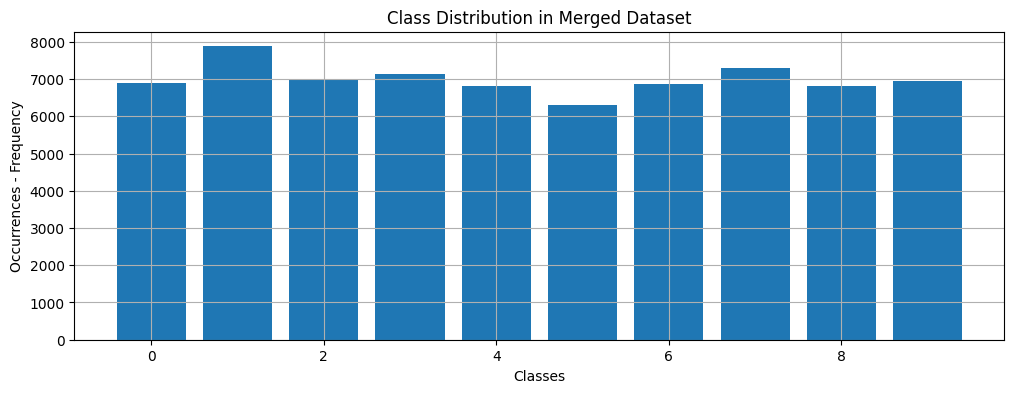

In [ ]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [ ]:
from collections import defaultdict

def plot_class_averages(dataloader):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    sums = defaultdict(lambda: torch.zeros(28, 28))
    counts = defaultdict(int)

    # Iterate over the DataLoader to accumulate sums and counts
    for batch_idx, (data, target) in enumerate(dataloader):
        for img, label in zip(data, target):
            sums[int(label)] += img.squeeze(0)
            counts[int(label)] += 1

    # Calculate the average images for each class
    averages = {label: sums[label] / counts[label] for label in range(10)}

    # Plot the averages
    plt.figure(figsize=(12, 4))
    for i in classes:
        plt.subplot(2, 5, i + 1)
        plt.imshow(averages[i].numpy(), cmap='gray')
        plt.title(f'Class {i}')
        plt.axis('off')

    plt.show()

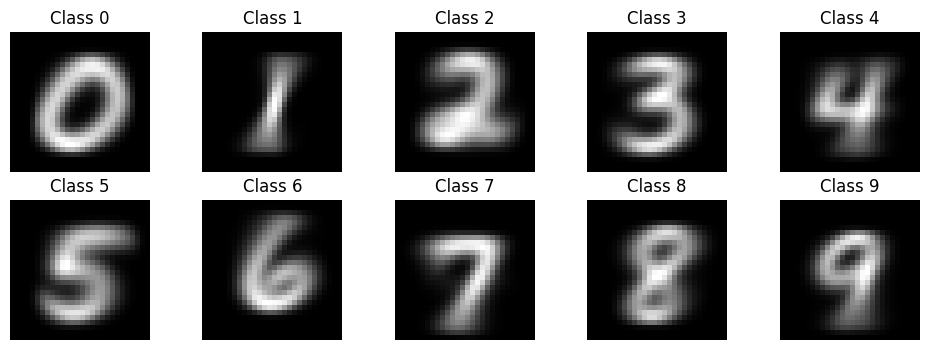

In [ ]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    input_dim = 784
    hidden_dim = 400
    def __init__(self, latent_dim=2):
        # TODO
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc3 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, self.hidden_dim)
        self.fc5 = nn.Linear(self.hidden_dim, self.input_dim)

    def encode(self, x):
        # TODO
        h = F.relu(self.fc1(x))              # from input to hidden layer
        return self.fc2(h), self.fc3(h)      # from the hidden layer to (mu, logvar)

    def reparameterization(self, mean, logvar):
        # TODO
        epsilon = torch.randn(1)                         # epsilon ~ N(0,1)
        return mean + epsilon * torch.exp(logvar / 2)    # mu + exp(logvar/2) * epsilon ~ N(mu, exp(logvar)=var)

    def decode(self, x):
        # TODO
        h = F.relu(self.fc4(x))              # from latent space to  hidden layer
        #return F.relu(self.fc5(h))           # and from hidden layer to the image space  --- sigmoid
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        # TODO
        mu , logvar = self.encode(x)
        z = self.reparameterization(mu, logvar)
        x_recontructed = self.decode(z)
        return x_recontructed, mu, logvar


In [ ]:
print(device)
model = VAE().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

cuda


# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # TODO
    reconst_loss = F.binary_cross_entropy(x, x_hat, size_average=False)
    kl_div = (-0.5) * torch.sum( 1 + log_var - (mean**2) - torch.exp(log_var) )
    return reconst_loss + kl_div


Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [ ]:
device = torch.device("cuda")
model.cuda()

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=2, bias=True)
  (fc3): Linear(in_features=400, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)

In [ ]:
def plot_losses(losses):
    # TODO
    epoch_num = 50
    epochs = range(1,1+epoch_num)
    plt.figure()
    plt.plot(losses, epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training')
    plt.grid(True)
    plt.show()


# def train(model, optimizer, n_epochs=50, losses=losses, merged_loader=merged_loader):
#     # TODO
#     for epoch in range(n_epochs):
#         print(device)
#         for i, (data, target) in enumerate(merged_loader):
#             x = data.to(device).view(-1, 784)
#             x_reconst, mu, logvar = model(x)
#             loss = loss_function(x, x_reconst, mu, logvar)
#             losses.append(loss)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             if (i+1) % 10 == 0:
#                 print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
#                    .format(epoch+1, n_epochs, i+1, len(merged_loader), loss.item()))

def train(model, optimizer, dataloader, n_epochs=50, losses=[]):
    model.train()
    for epoch in range(n_epochs):
        train_loss = 0
        print(device)
        for i, (data, _) in enumerate(dataloader):
            x = data.to('cuda').view(-1, 784)
            x_reconstructed, mu, logvar = model(x)
            loss = loss_function(x, x_reconstructed, mu, logvar)
            train_loss += loss.item()  # Use loss.item() to avoid accumulation issues
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"Epoch[{epoch+1}/{n_epochs}], Step[{i+1}/{len(dataloader)}], Reconst Loss: {loss.item():.4f}")

        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')


In [ ]:
dataloader = merged_loader # .to("cuda")  # Assuming merged_loader is your DataLoader
train(model, optimizer, dataloader, n_epochs=50, losses=losses)

AttributeError: 'DataLoader' object has no attribute 'to'

In [ ]:
losses += train(model, optimizer)

cuda:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch

# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     print('HAHA! MY BELOVED GPU IS AVAILABLE')
# else:
#     device = torch.device('cpu')
#     print('HEEBWORKING ON CPU FOR CRYING OUT LOUD')
device = 'cpu'

class VAE(nn.Module):
    input_dim = 784
    hidden_dim = 400

    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc3 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, self.hidden_dim)
        self.fc5 = nn.Linear(self.hidden_dim, self.input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    # def reparameterization(self, mean, logvar):
    #     epsilon = torch.randn_like(mean)  # Ensure epsilon is on the same device
    #     return mean + epsilon * torch.exp(logvar / 2)
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean, device=mean.device)  # Ensures `epsilon` is on the same device as `mean`
        return mean + epsilon * torch.exp(logvar / 2)

    def decode(self, x):
        h = F.relu(self.fc4(x))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Reshape inside the model
        mu, logvar = self.encode(x)
        z = self.reparameterization(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

def loss_function(x, x_hat, mean, log_var):
    #reconst_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')  # Updated to use reduction='sum'
    reconst_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_div = (-0.5) * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconst_loss + kl_div

def train(model, optimizer, n_epochs=50, losses=[]):
    model.train()
    for epoch in range(n_epochs):
        train_loss = 0
        for i, (data, _) in enumerate(dataloader):
            data = data.to(device).view(-1, 784)  # Reshape and move data to GPU
            x_reconstructed, mu, logvar = model(data)

            # Check if x_reconstructed values are within the range [0, 1]
            if not torch.all((0 <= x_reconstructed) & (x_reconstructed <= 1)):
                print("Warning: x_reconstructed values out of range [0, 1]")
                x_reconstructed = torch.clamp(x_reconstructed, 0, 1)

            loss = loss_function(data, x_reconstructed, mu, logvar)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"Epoch[{epoch+1}/{n_epochs}], Step[{i+1}/{len(dataloader)}], Reconst Loss: {loss.item():.4f}")

        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')


# Ensure CUDA launch blocking
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
dataloader = merged_loader  # Use the DataLoader directly
train(model, optimizer, n_epochs=50, losses=losses)


Epoch[1/50], Step[10/1094], Reconst Loss: 45046.0234
Epoch[1/50], Step[20/1094], Reconst Loss: 40031.3320
Epoch[1/50], Step[30/1094], Reconst Loss: 39807.6133
Epoch[1/50], Step[40/1094], Reconst Loss: 38987.3789
Epoch[1/50], Step[50/1094], Reconst Loss: 38133.2695
Epoch[1/50], Step[60/1094], Reconst Loss: 37109.1719
Epoch[1/50], Step[70/1094], Reconst Loss: 38583.0039
Epoch[1/50], Step[80/1094], Reconst Loss: 37292.5977
Epoch[1/50], Step[90/1094], Reconst Loss: 37665.3711
Epoch[1/50], Step[100/1094], Reconst Loss: 39521.1758
Epoch[1/50], Step[110/1094], Reconst Loss: 37433.1133
Epoch[1/50], Step[120/1094], Reconst Loss: 38285.0742
Epoch[1/50], Step[130/1094], Reconst Loss: 37340.4727
Epoch[1/50], Step[140/1094], Reconst Loss: 35025.9727
Epoch[1/50], Step[150/1094], Reconst Loss: 38591.2656
Epoch[1/50], Step[160/1094], Reconst Loss: 39100.4844
Epoch[1/50], Step[170/1094], Reconst Loss: 35277.9062
Epoch[1/50], Step[180/1094], Reconst Loss: 36766.6016
Epoch[1/50], Step[190/1094], Reconst 

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [ ]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    vae.eval()
    latent_vectors = []
    labels = []
    for i, (data, target) in enumerate(dataloader):
        if i >= batch_count:
            break
        data = data.to(next(vae.parameters).device)
        data = data.view(-1, 784)

        with torch.no_grad():
            mu, logvar = vae.decode()
            z = vae.reparameterization(mu, logvar)

        latent_vectors.append(z.cpu())
        labels.append(target.cpu())
    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Labels')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(title)
    plt.show()

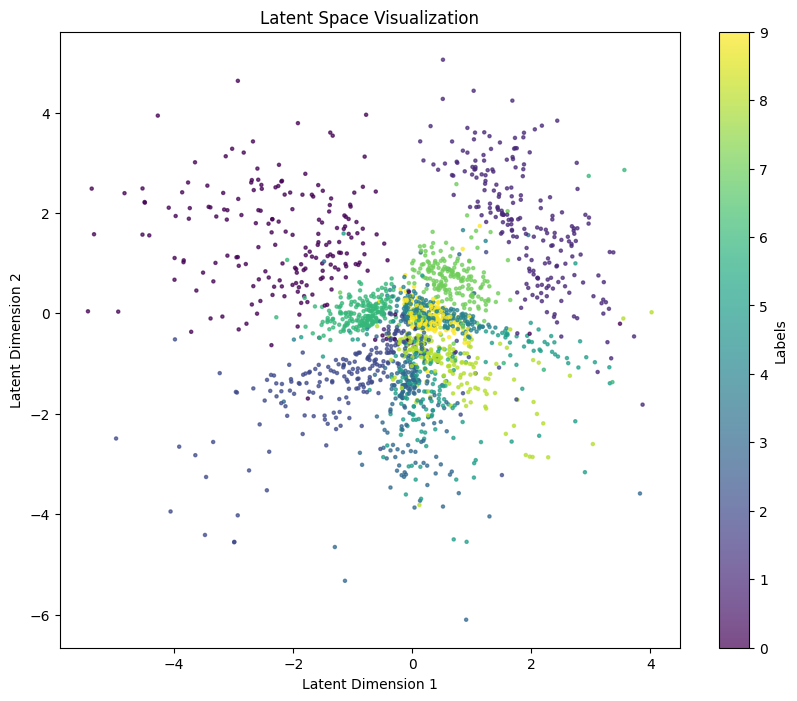

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    vae.eval()  # Set the model to evaluation mode
    latent_vectors = []
    labels = []

    for i, (data, target) in enumerate(dataloader):
        if i >= batch_count:
            break
        data = data.to(next(vae.parameters()).device)  # Corrected device assignment
        data = data.view(-1, 784)

        with torch.no_grad():
            mu, logvar = vae.encode(data)  # Use encode to get mu and logvar
            z = vae.reparameterization(mu, logvar)

        latent_vectors.append(z.cpu())
        labels.append(target.cpu())

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Labels')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(title)
    plt.show()

visualize(model, merged_loader)

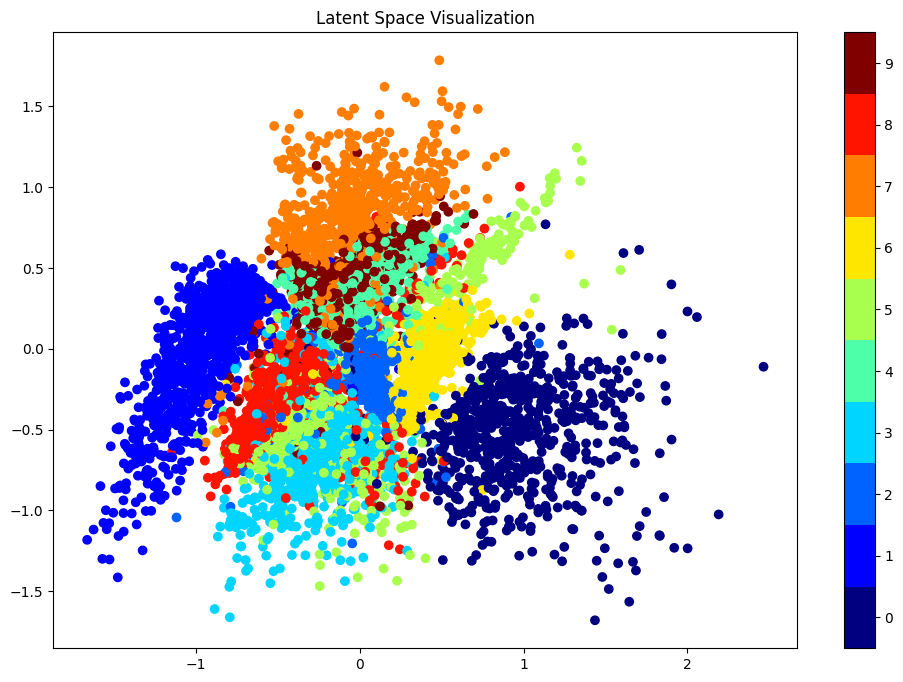

In [ ]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [ ]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    pass

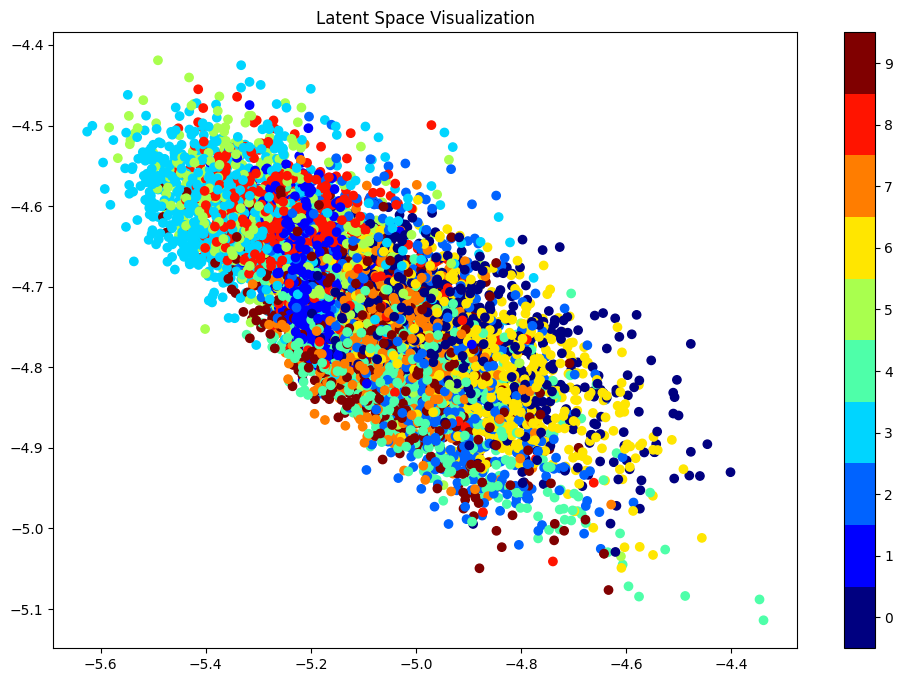

In [ ]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

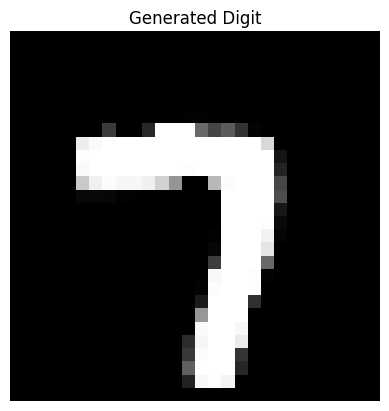

In [ ]:
def generate_digit(mean, var, model):
    # TODO: Return the generated image
    z = model.reparameterization(mean, var)

    # Use the decoder to generate an image
    with torch.no_grad():
        generated_image = model.decode(z)

    return generated_image

# Example usage
mean = torch.zeros(1, 2).to(device)  # Example mean (latent_dim=2)
var = torch.zeros(1, 2).to(device)   # Example variance (latent_dim=2)
generated_image = generate_digit(mean, var, model)

# Display the generated image
import matplotlib.pyplot as plt

plt.imshow(generated_image.view(28, 28).cpu().numpy(), cmap='gray')
plt.title('Generated Digit')
plt.axis('off')
plt.show()


Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [ ]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid

    # TODO: Generate images for the grid

    # TODO: Display the results
    pass

In [ ]:
import torch

# Path to save the model
save_path = "vae_model.ckpt"

# Save the model
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to vae_model.ckpt


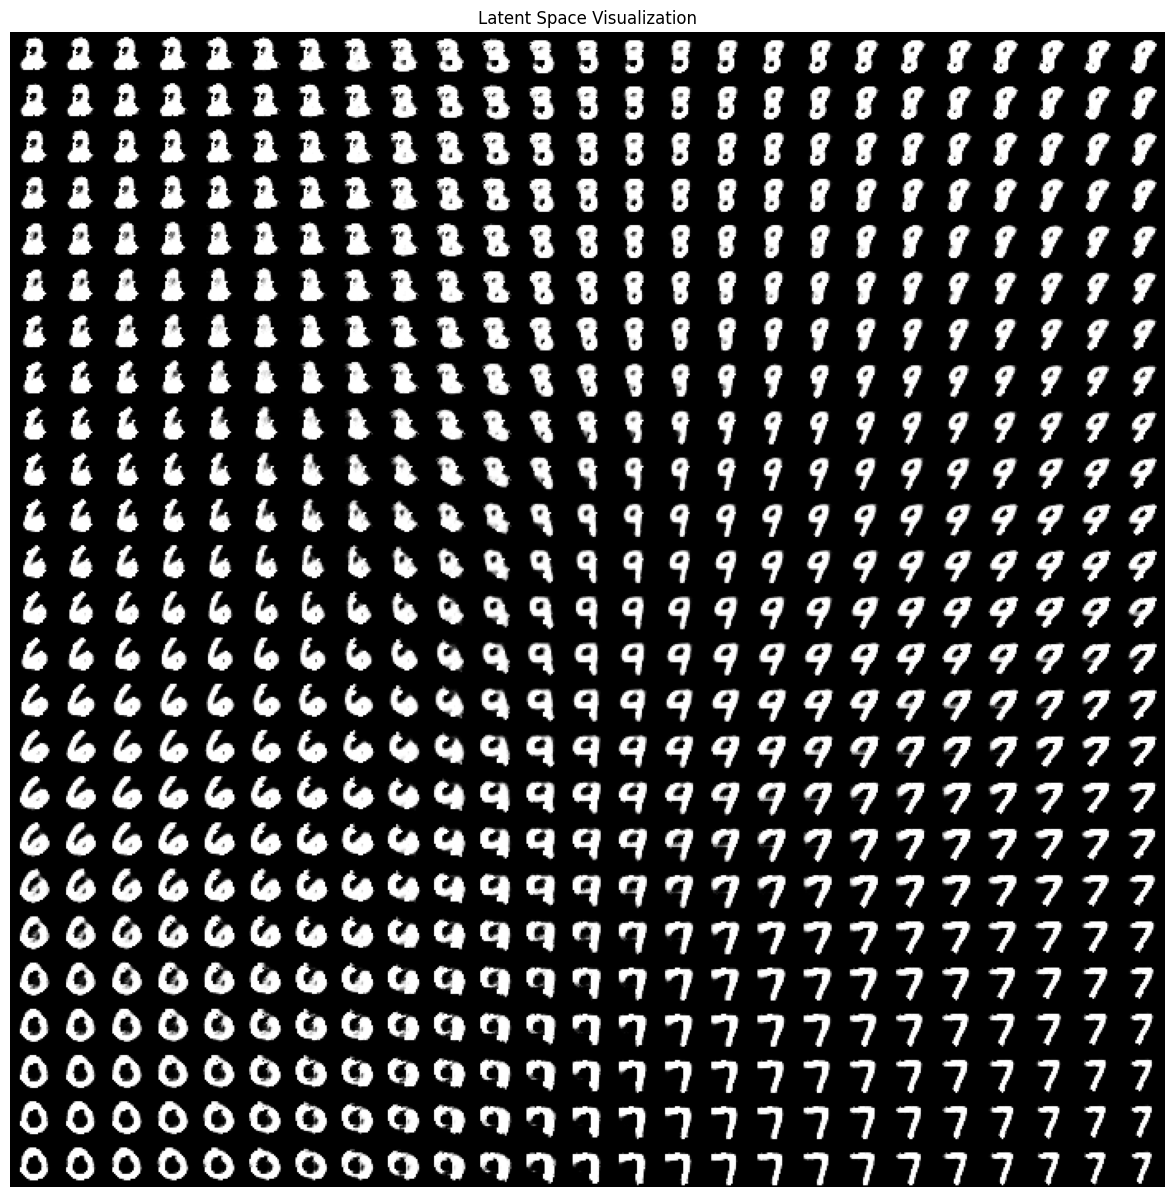

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # Create a figure to display the grid
    figure = np.zeros((digit_size * n, digit_size * n))

    # Generate a grid of points in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(next(model.parameters()).device)
                x_decoded = model.decode(z_sample).cpu().numpy()
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    # Plot the figure
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.title('Latent Space Visualization')
    plt.axis('off')
    plt.show()

# Example usage
plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15)


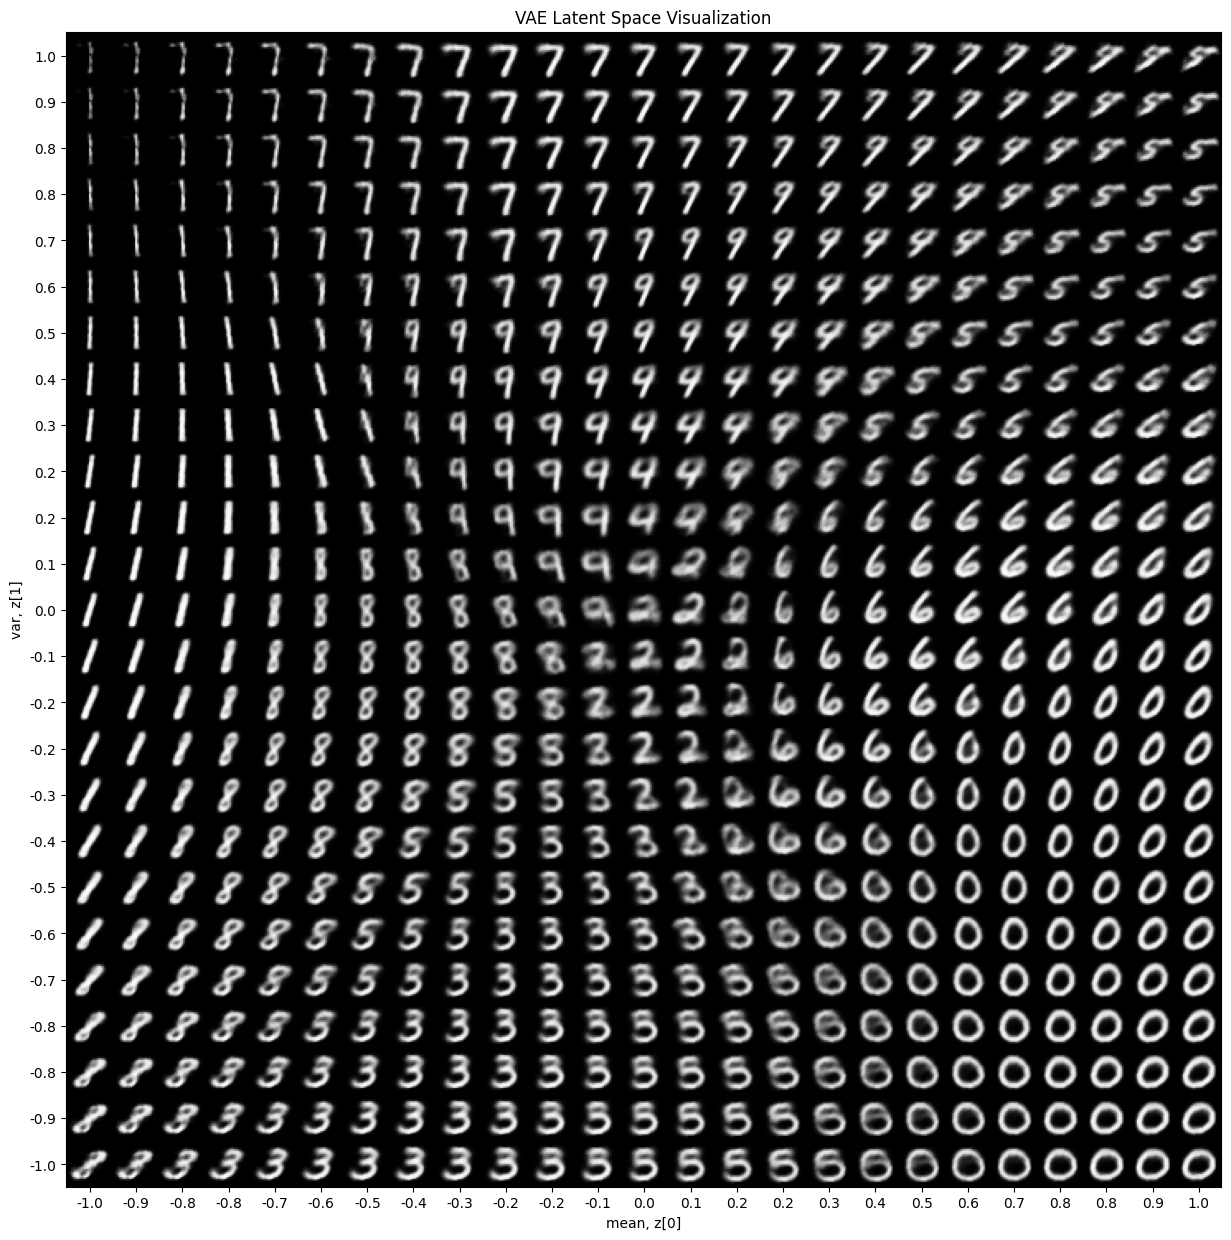

In [ ]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*